In [ ]:
import pandas as pd
import numpy as np
import plot_params
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
import scipy.stats as stats

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import export_graphviz

plot_params.apply_rcparams()

include EDA, correlations -> matrix, mutual information, dont use accuracy -> f1 score look, multiple models with the pipeline, multicollinearity need to drop one OHE, feature selection, hyperparameter tuning, classification tree no, random forest, gradiaent boost or catboost, svm, linear model ridge classifier. make dataset imbalance?

In [3]:
df = pd.read_csv("mushrooms.csv")
df = df.rename(columns={'class' : 'edibility'})

In [4]:
print(df.info())
print(df.isnull().sum())
print((df.isnull().sum() / len(df)) * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   edibility                 8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [5]:
print(df.describe())
print(df.describe(include=['object']))

       edibility cap-shape cap-surface cap-color bruises  odor  \
count       8124      8124        8124      8124    8124  8124   
unique         2         6           4        10       2     9   
top            e         x           y         n       f     n   
freq        4208      3656        3244      2284    4748  3528   

       gill-attachment gill-spacing gill-size gill-color  ...  \
count             8124         8124      8124       8124  ...   
unique               2            2         2         12  ...   
top                  f            c         b          b  ...   
freq              7914         6812      5612       1728  ...   

       stalk-surface-below-ring stalk-color-above-ring stalk-color-below-ring  \
count                      8124                   8124                   8124   
unique                        4                      9                      9   
top                           s                      w                      w   
freq               

In [6]:
print(df.nunique())

edibility                    2
cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
dtype: int64


In [7]:
label_encoder = preprocessing.LabelEncoder()
df_encoded = df.apply(lambda col: label_encoder.fit_transform(col))

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Compute correlation matrix for categorical features
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
cramers_matrix = pd.DataFrame( \
    np.zeros((len(categorical_cols), len(categorical_cols))), 
    index=categorical_cols, columns=categorical_cols)

# Calculate Cramér's V for each pair of categorical variables
for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

mask = np.triu(np.ones_like(cramers_matrix, dtype=bool))

C:\Users\frang\AppData\Local\Temp\ipykernel_13800\687213207.py:6: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
C:\Users\frang\AppData\Local\Temp\ipykernel_13800\687213207.py:6: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
C:\Users\frang\AppData\Local\Temp\ipykernel_13800\687213207.py:6: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
C:\Users\frang\AppData\Local\Temp\ipykernel_13800\687213207.py:6: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
C:\Users\frang\AppData\Local\Temp\ipykernel_13800\687213207.py:6: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
C:\Users\frang\AppData\Local\Temp\ipykernel_13800\687213207.py:6: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
C:\Users\f

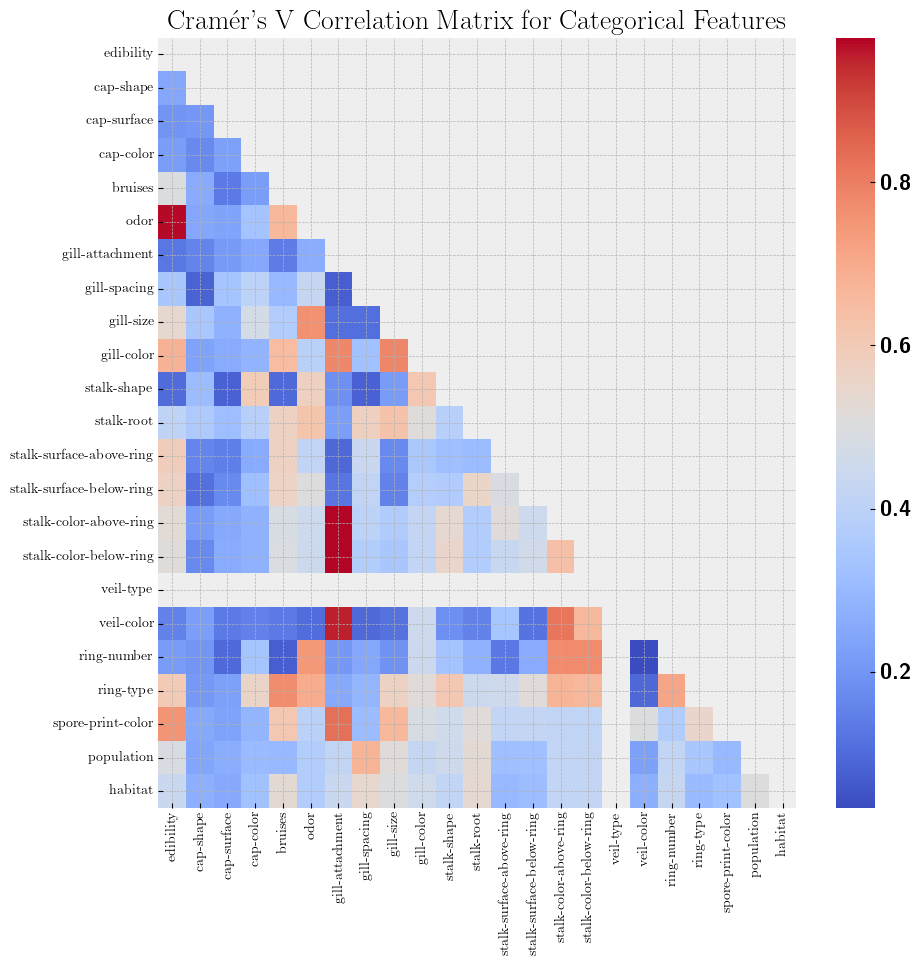

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cramers_matrix.astype(float), 
                 annot=False, cmap="coolwarm", 
                 fmt=".2f", mask=mask, annot_kws={'size':10})
plt.title("Cramér's V Correlation Matrix for Categorical Features")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [10]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
X = df_encoded.iloc[:, 1:]
Y = df_encoded['edibility']
X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, test_size=0.2, random_state=42)
rfc = rfc.fit(X_train,Y_train)

In [21]:
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
f1score = f1_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
print("f1 Score:", f1score)

Accuracy: 1.0
f1 Score: 1.0


In [12]:
tree = rfc.estimators_[0]
dot_data = export_graphviz(tree, out_file=None, feature_names=X_train.columns,
                           class_names=['Edible', 'Poisonous'], 
                           filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph.render("random_forest_tree", view=True)

'random_forest_tree.pdf'

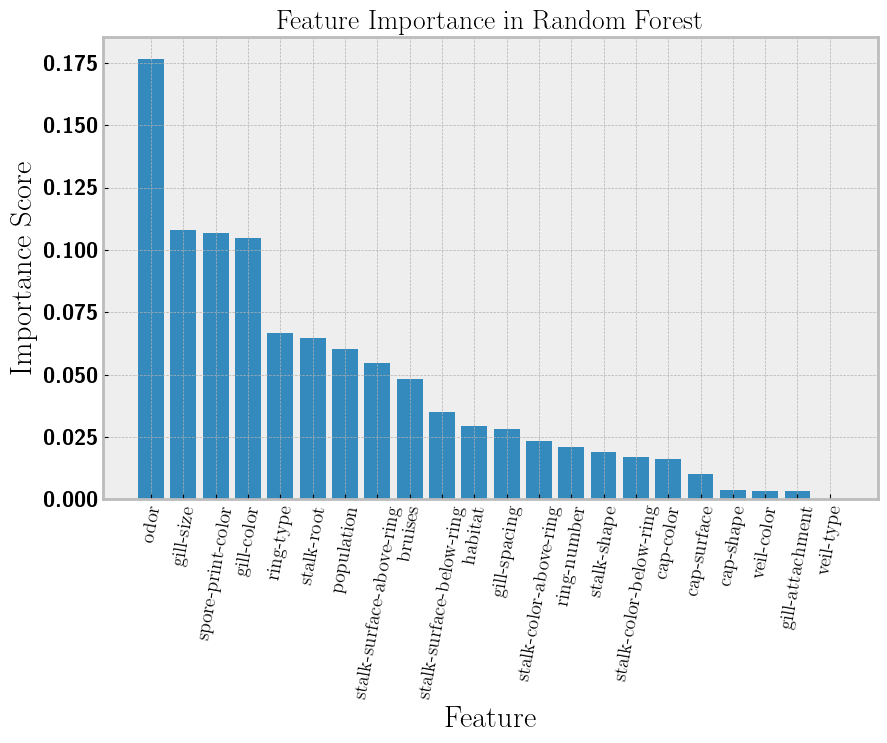

In [13]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns
plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [features[i] for i in indices], 
           rotation=80)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

what does this plot mean? more variance

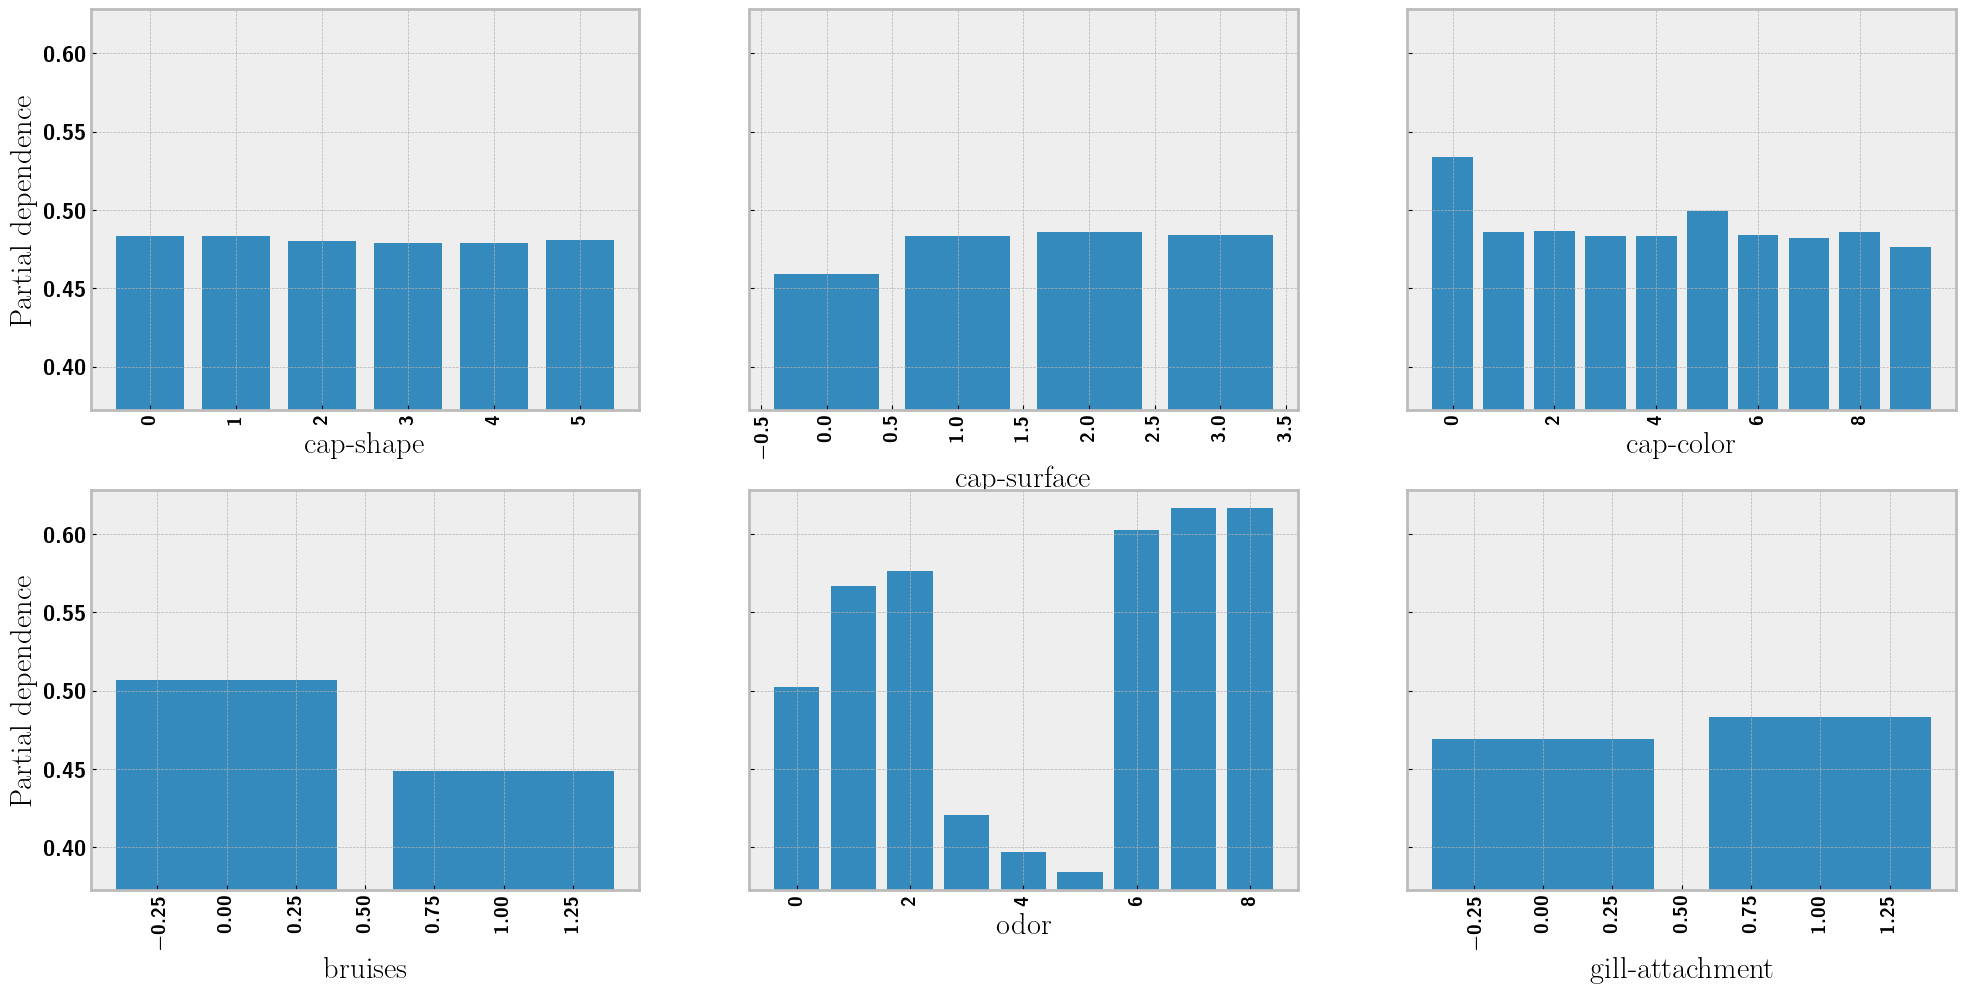

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
labels_0 = label_encoder.classes_
#ax.set_xticklabels(odor_labels)
PartialDependenceDisplay.from_estimator(rfc, X_train, features=[0,1,2,3,4,5], 
                                        feature_names=X_train.columns, ax=ax, 
                                        categorical_features=[0,1,2,3,4,5])
plt.tight_layout()
plt.show()
